In [1]:
#Imports
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm.notebook import tqdm
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchio as tio
from torchio import AFFINE, DATA

from PIL import Image

import Model
import nibabel as nib
import eval_utils
import SimpleITK as sitk
import copy

In [2]:
#Set a path to save the final weights to
#PATH = ""

#Settings and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("using gpu")
else:
    print("using cpu")

bs_train, bs_val, bs_test = 16, 8, 1
epochs = 6
lr = 0.0001

PATH = '/Users/raphaelbenichou/Desktop/weights_ml/model_state_dict.pt' 

#Create lists for the paths of training images and training masks 
isles_data_dir = '/Users/raphaelbenichou/Downloads/Dataset001_ISLES22forUNET'

dwi_path_1 = os.path.join(isles_data_dir,'imagesTr/ISLES_247_0001.nii.gz')
dwi_path_2 = os.path.join(isles_data_dir,'imagesTr/ISLES_248_0001.nii.gz')
dwi_path_3 = os.path.join(isles_data_dir,'imagesTr/ISLES_249_0001.nii.gz')
dwi_path_4 = os.path.join(isles_data_dir,'imagesTr/ISLES_250_0001.nii.gz')

mask_path_1 = os.path.join(isles_data_dir, 'labelsTr/ISLES_247.nii.gz')
mask_path_2 = os.path.join(isles_data_dir, 'labelsTr/ISLES_248.nii.gz')
mask_path_3 = os.path.join(isles_data_dir, 'labelsTr/ISLES_249.nii.gz')
mask_path_4 = os.path.join(isles_data_dir, 'labelsTr/ISLES_250.nii.gz')
train_files = [dwi_path_1,dwi_path_2,dwi_path_3,dwi_path_4]
mask_files = [mask_path_1,mask_path_2,mask_path_3,mask_path_4]


        



using cpu


In [3]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.25)
df_train, df_val = train_test_split(df_train,test_size = 1/3)

In [4]:
def nibabel_to_pil(array_proxy):
    # Load the data from the nibabel array proxy
        array_data = np.array(array_proxy)
        
       
        
        # Convert the numpy array to a PIL image
        pil_image = Image.fromarray(array_data.astype(np.uint8))
        
        return pil_image

In [5]:
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):

        image = nibabel_to_pil(image)
        mask = nibabel_to_pil(mask)

        # Resize
        resize = transforms.Resize(size=(256, 256))
        image = resize(image)
        mask = resize(mask)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        return image, mask

    def __getitem__(self, index):
        image = (nib.load(self.image_paths[index])).dataobj[...,80]
        mask = (nib.load(self.target_paths[index])).dataobj[...,80]
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

train_dataset = MyDataset(df_train["filename"].values.tolist(), df_train["mask"].values.tolist())
val_dataset = MyDataset(df_val['filename'].values.tolist(), df_val['mask'].values.tolist())
test_dataset = MyDataset(df_test['filename'].values.tolist(), df_test["mask"].values.tolist())

train_dataloader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=bs_val, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs_test, shuffle=True)



In [6]:
def dc_loss(pred, target):
    smooth = 100

    predf = pred.view(-1)
    targetf = target.view(-1)
    intersection = (predf * targetf).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (predf.sum() + targetf.sum() + smooth))

In [7]:
model=Model.UNet().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr,betas=(0.9,0.999))

In [8]:
#Training function 
def train(model, epochs):
    
    #Keep track of average training and validation losses for each epoch
    avg_train_losses = []
    avg_val_losses = []
    
    #Trigger for earlystopping
    earlystopping = False 

    #Training loop
    for epoch in range(epochs):
        
        #Record the training and validation losses for each batch in this epoch
        train_losses = []
        val_losses = []

        model.train()

        loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), leave = False)
        for batch, (images, targets) in loop:

            images = images.to(device)
            targets = targets.to(device)

            model.zero_grad()
            pred = model(images)
            loss = dc_loss(pred, targets)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
                        
            with torch.no_grad():     #Show some samples at the first batch of each epoch 
                if batch == 1:
                    torch.save(model.state_dict(), PATH)

                    model.eval()

                    (img, mask) = next(iter(test_dataloader))
                    img = img.to(device)
                    mask = mask.to(device)
                    mask = mask[0]
                    pred = model(img)

                    plt.figure(figsize=(12,12))
                    plt.subplot(1,3,1)
                    plt.imshow(np.squeeze(img.cpu().numpy()).transpose(1,2,0))
                    plt.title('Original Image')
                    plt.subplot(1,3,2)
                    plt.imshow((mask.cpu().numpy()).transpose(1,2,0).squeeze(axis=2), alpha=0.5)
                    plt.title('Original Mask')
                    plt.subplot(1,3,3)
                    plt.imshow(np.squeeze(pred.cpu()) > .5)
                    plt.title('Prediction')
                    plt.show()

                    model.train()

                
        model.eval()
        
        with torch.no_grad():     #Record and print average validation loss for each epoch 
            for val_batch, (val_images, val_targets) in enumerate(val_dataloader):
                val_images = val_images.to(device)
                val_targets = val_targets.to(device)
                val_pred = model(val_images.detach())

                val_loss = dc_loss(val_pred, val_targets).item()

                val_losses.append(val_loss)

            epoch_avg_train_loss = np.average(train_losses)
            epoch_avg_val_loss = np.average(val_losses)
            avg_train_losses.append(epoch_avg_train_loss)
            avg_val_losses.append(epoch_avg_val_loss)

            print_msg = (f'train_loss: {epoch_avg_train_loss:.5f} ' + f'valid_loss: {epoch_avg_val_loss:.5f}')

            print(print_msg)
        
        if epoch > 5:     #Early stopping with a patience of 1 and a minimum of 5 epochs 
            if avg_val_losses[-1]>=avg_val_losses[-2]:
                print("Early Stopping Triggered With Patience 1")
                torch.save(model.state_dict(), PATH)
                earlystopping = True 
        if earlystopping:
            break

    return  model, avg_train_losses, avg_val_losses

In [9]:
best_model, avg_train_losses, avg_val_losses = train(model, epochs)

  0%|          | 0/1 [00:00<?, ?it/s]

train_loss: 0.99831 valid_loss: 0.99681


  0%|          | 0/1 [00:00<?, ?it/s]

train_loss: 0.99822 valid_loss: 0.99681


  0%|          | 0/1 [00:00<?, ?it/s]

train_loss: 0.99815 valid_loss: 0.99680


  0%|          | 0/1 [00:00<?, ?it/s]

train_loss: 0.99810 valid_loss: 0.99680


  0%|          | 0/1 [00:00<?, ?it/s]

train_loss: 0.99805 valid_loss: 0.99680


  0%|          | 0/1 [00:00<?, ?it/s]

train_loss: 0.99800 valid_loss: 0.99679


In [10]:
test_model = Model.UNet().to(device)
test_model.load_state_dict(torch.load(PATH))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/raphaelbenichou/Desktop/weights_ml/model_state_dict.pt'

ValueError: axes don't match array

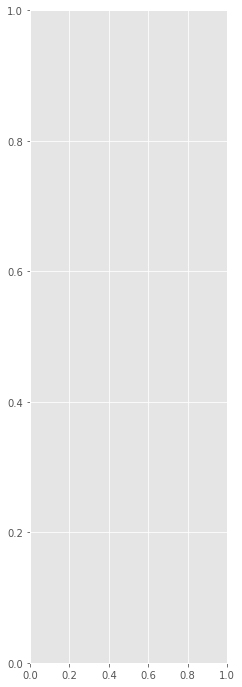

In [16]:
model.eval()

(img, mask) = next(iter(test_dataloader))
img = img.to(device)
mask = mask.to(device)
mask = mask[0]
pred = model(img)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img.cpu().numpy()).transpose(3,2,0))
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow((mask.cpu().numpy()).transpose(1,2,0).squeeze(axis=2), alpha=0.5)
plt.title('Original Mask')
plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred.cpu()) > .5)
plt.title('Prediction')
plt.show()
